In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
import re
%matplotlib inline

### Settings

In [2]:
# Path settings
base_path_to_csv = "/home/till/SharedFolder/trained_models/night-drive/weather_classifier/"

# Settings for epoch selection method
which_mode = "best_onemetric"  # Options: ["manual", "common", "best_onemetric", "best_eachmetric"]
# epoch to use for mode "common" epoch
epoch_common = 40  # Options: [1, 40]
# metric to use for mode "best_onemetric"
onemetric = "f1_score_macro"  # Options: ['f1_score_weighted', 'f1_score_micro', 'f1_score_macro', 'accuracy', 'roc_auc_micro', 'roc_auc_macro', 'pr_micro', 'pr_macro', 'mcc', 'train_loss', 'train_dev_loss']
# manual list of epochs for mode "manual"
list_selepochs = [[10, 10, 13, 10, 13, 10], # for each trial of run "without_cloudy"
                  [10, 10, 10, 10, 10, 10]] # for each trial of run "with_cloudy"

### Select classifier results

In [3]:
# load results and pick best epochs
# for each run and trial, these results contain a variety of metrics for all epochs for all sub-splits (train, valid, etc)
df_sel = pd.DataFrame()
df_sel_epochs = pd.DataFrame()
df_all = pd.DataFrame()
list_runs = ["without_cloudy", "with_cloudy"]
list_trials = ["train_A_over", "train_B_over", "train_C_over", "train_A_over_ganaug_025", "train_A_over_ganaug_050", "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase"]
for r, run in enumerate(list_runs):  # for each set of classifier runs
    for t, trial in enumerate(list_trials):  # for each data set
        path_to_csv = os.path.join(base_path_to_csv,run,trial)
        csv_files = glob.glob(path_to_csv + "/*.csv")
        ### Combine CSVs into one DataFrame ###
        df = pd.DataFrame()
        for csv_file in csv_files:
            df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
            df = df.reset_index(drop = True)
        ### Some preprocessing ###
        #
        df = df.drop(columns = ["weights"])
        #
        df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
        df = df.sort_values(by = ["data", "epoch"])
        df = df.reset_index(drop = True)
        ### Load training log file ###
        train_log_file = glob.glob(path_to_csv + "/*.txt")
        assert(len(train_log_file) == 1)
        df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
        df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
        df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
        df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
        df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
        df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
        ### Combine loss, scores
        df_combined = df_loss.groupby(by = ["epoch"]).median()
        df_combined = df_combined.drop(columns = ["batch"])
        ### Combine loss, scores into metrics
        # df = df.join(df_combined, on="epoch")
        # stash best results according to selected method
        if which_mode in ["manual", "common"]:
            if which_mode == "manual":  # manual list of epochs, e.g. balancing overfitting and performance
                sel_epoch = list_selepochs[r][t]
            elif which_mode == "common":  # same epoch for every run
                sel_epoch = epoch_common
            rw = df.query("epoch==@sel_epoch").copy()
            rw.loc[:, "trial"] = list_trials[t]
            rw.loc[:, "run"] = list_runs[r]
            df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_onemetric":  # for each run, the best epoch accoding to one metric is selected 
            sel_epoch = []
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                rw = df_subsplit.loc[df_subsplit[onemetric].idxmax(), :].to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_eachmetric":  # all runs and metrics are evaluated independently on their best epoch 
            # find best epoch metric for each metric
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                sel_epochs = df_subsplit.loc[:,df_subsplit.columns[df_subsplit.dtypes == "float64"]].idxmax().to_frame().T
                sel_epochs.loc[:, "trial"] = list_trials[t]
                sel_epochs.loc[:, "run"] = list_runs[r]
                rw = df_subsplit.max().to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel_epochs = df_sel_epochs.append(sel_epochs, ignore_index=True, sort=True) 
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 

        # stash all data
        df_all = pd.concat([df_all, df], axis=1)

In [4]:
df.head(5)

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.416610,0.357603,0.362211,0.357603,0.507598,0.558730,0.758074,0.418042,0.556142,0.217372
1,2,test,0.617604,0.548325,0.515300,0.548325,0.635635,0.775693,0.860508,0.653937,0.708613,0.354225
2,3,test,0.773570,0.740335,0.637989,0.740335,0.716836,0.897251,0.894623,0.825988,0.769045,0.483436
3,4,test,0.813300,0.795103,0.678030,0.795103,0.735718,0.926422,0.905948,0.873937,0.792658,0.536706
4,5,test,0.811756,0.793814,0.676484,0.793814,0.736812,0.929515,0.910921,0.878833,0.803043,0.535187


In [5]:
df_sel.head(5)

,accuracy,accuracy_balanced,data,epoch,f1_score_macro,f1_score_micro,f1_score_weighted,mcc,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro,run,trial
0,0.89884,0.795133,test,30,0.802813,0.89884,0.897838,0.71684,0.855978,0.947102,0.931167,0.969566,without_cloudy,train_A_over
1,0.936877,0.921798,test_daytime,28,0.910764,0.936877,0.937441,0.86818,0.954222,0.977094,0.986085,0.987605,without_cloudy,train_A_over
2,0.867368,0.667416,test_night,18,0.675203,0.867368,0.866626,0.523829,0.708182,0.911146,0.848092,0.949318,without_cloudy,train_A_over
3,0.923899,0.92391,train_dev_A_over,12,0.923793,0.923899,0.923793,0.886022,0.972457,0.973417,0.98534,0.984951,without_cloudy,train_A_over
4,0.891753,0.801035,valid,32,0.792849,0.891753,0.892733,0.706653,0.855723,0.949033,0.937862,0.970616,without_cloudy,train_A_over


In [6]:
# print best epochs for each metric, if available
if which_mode == "best_eachmetric":
    print(df_sel_epochs.head(12))

### Print results for best epochs gouped by split

In [7]:
# Selection (and order) of columns to be printed
meta2print = ["epoch", "trial", "run"]
metrics2print = ['accuracy', 'accuracy_balanced', 'f1_score_weighted', 'f1_score_micro', 'f1_score_macro', 'roc_auc_micro', 'roc_auc_macro', 'pr_micro', 'pr_macro', 'mcc']
cols2print = [*meta2print, *metrics2print]
# rename train dev sets
df_sel.data = df_sel.data.apply(lambda x: re.sub(r"_[A-C]_[a-zA-Z0-9_]*", r"", x))

#### Valid-All

In [8]:
split = "valid"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "=== Results for best manual epoch ===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== valid === Results for best manual epoch ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,32,train_A_over,without_cloudy,0.891753,0.801035,0.892733,0.891753,0.792849,0.970616,0.937862,0.949033,0.855723,0.706653
1,39,train_B_over,without_cloudy,0.897552,0.812419,0.898291,0.897552,0.80638,0.97604,0.954027,0.958424,0.880939,0.721004
2,34,train_C_over,without_cloudy,0.88982,0.82283,0.893128,0.88982,0.795151,0.971359,0.95276,0.948889,0.86955,0.714645
3,20,train_A_over_ganaug_025,without_cloudy,0.887242,0.803109,0.889444,0.887242,0.786326,0.969707,0.944605,0.946294,0.860692,0.700446
4,27,train_A_over_ganaug_050,without_cloudy,0.884021,0.80723,0.886765,0.884021,0.786242,0.967604,0.942439,0.944032,0.856481,0.694922
5,23,train_B_over_ganaug_025,without_cloudy,0.91366,0.827906,0.913302,0.91366,0.831803,0.977541,0.953268,0.960559,0.882669,0.760236
6,21,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.896907,0.788312,0.896036,0.896907,0.795429,0.972449,0.940554,0.951353,0.85251,0.711737
7,36,train_A_over,with_cloudy,0.832,NaN,0.830636,0.832,0.751538,0.953876,0.927669,0.886898,0.805484,0.698413
8,34,train_B_over,with_cloudy,0.839,NaN,0.839202,0.839,0.777637,0.958947,0.940212,0.900045,0.83977,0.715969
9,35,train_C_over,with_cloudy,0.8285,NaN,0.829755,0.8285,0.76104,0.956511,0.939627,0.894224,0.834233,0.699818


#### Valid-Night

In [9]:
split = "valid_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== valid_night ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,29,train_A_over,without_cloudy,0.871579,0.692953,0.873454,0.871579,0.696724,0.9558,0.869847,0.922397,0.716398,0.549977
1,39,train_B_over,without_cloudy,0.887368,0.738505,0.888559,0.887368,0.735891,0.966657,0.911709,0.942573,0.79225,0.606989
2,35,train_C_over,without_cloudy,0.876842,0.77774,0.883492,0.876842,0.731714,0.96158,0.919449,0.930945,0.80382,0.614871
3,28,train_A_over_ganaug_025,without_cloudy,0.871579,0.693067,0.872744,0.871579,0.690314,0.958527,0.887535,0.925106,0.732034,0.55215
4,27,train_A_over_ganaug_050,without_cloudy,0.865263,0.71816,0.870254,0.865263,0.696564,0.953647,0.887129,0.919382,0.743495,0.555839
5,31,train_B_over_ganaug_025,without_cloudy,0.907368,0.74254,0.904529,0.907368,0.768124,0.972023,0.912868,0.950205,0.807813,0.655402
6,23,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.886316,0.667294,0.881217,0.886316,0.697862,0.961297,0.870882,0.931004,0.710117,0.567988
7,29,train_A_over,with_cloudy,0.834,NaN,0.834254,0.834,0.632421,0.939911,0.838191,0.855749,0.635871,0.519834
8,35,train_B_over,with_cloudy,0.865,NaN,0.863639,0.865,0.703858,0.960063,0.887495,0.907321,0.738541,0.609369
9,39,train_C_over,with_cloudy,0.849,NaN,0.851635,0.849,0.687554,0.957516,0.89354,0.899728,0.737191,0.581551


In [10]:
print("\n===", split, "Difference to A ===")
one_half = df_cursplit.shape[0]//2
df_cursplit_diff = df_cursplit.copy()
for col in df_cursplit.columns:
    if not isinstance(df_cursplit.loc[0,col], str):
        df_cursplit_diff.loc[0:one_half-1,col] = df_cursplit_diff.loc[0:one_half-1,col] - df_cursplit.loc[0,col]
        df_cursplit_diff.loc[one_half:one_half*2-1,col] = df_cursplit_diff.loc[one_half:one_half*2-1,col] - df_cursplit.loc[one_half,col]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== valid_night Difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,0,train_A_over,without_cloudy,0,0,0,0,0,0,0,0,0,0
1,10,train_B_over,without_cloudy,0.0157895,0.0455521,0.0151051,0.0157895,0.039167,0.0108571,0.0418624,0.0201762,0.0758516,0.0570122
2,6,train_C_over,without_cloudy,0.00526316,0.0847869,0.0100379,0.00526316,0.03499,0.00578006,0.0496021,0.00854863,0.0874217,0.0648947
3,-1,train_A_over_ganaug_025,without_cloudy,0,0.000113921,-0.000709941,0,-0.00640987,0.00272659,0.0176877,0.00270919,0.0156359,0.00217352
4,-2,train_A_over_ganaug_050,without_cloudy,-0.00631579,0.0252077,-0.00320022,-0.00631579,-0.000159185,-0.00215346,0.0172821,-0.00301491,0.0270972,0.00586258
5,2,train_B_over_ganaug_025,without_cloudy,0.0357895,0.0495878,0.0310751,0.0357895,0.0714004,0.016223,0.0430214,0.0278086,0.0914151,0.105426
6,-6,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.0147368,-0.0256587,0.00776334,0.0147368,0.00113865,0.00549668,0.00103471,0.00860681,-0.0062815,0.0180109
7,0,train_A_over,with_cloudy,0,NaN,0,0,0,0,0,0,0,0
8,6,train_B_over,with_cloudy,0.031,NaN,0.0293848,0.031,0.0714373,0.0201517,0.0493043,0.0515716,0.10267,0.0895356
9,10,train_C_over,with_cloudy,0.015,NaN,0.0173809,0.015,0.0551333,0.017605,0.0553491,0.043979,0.10132,0.0617173


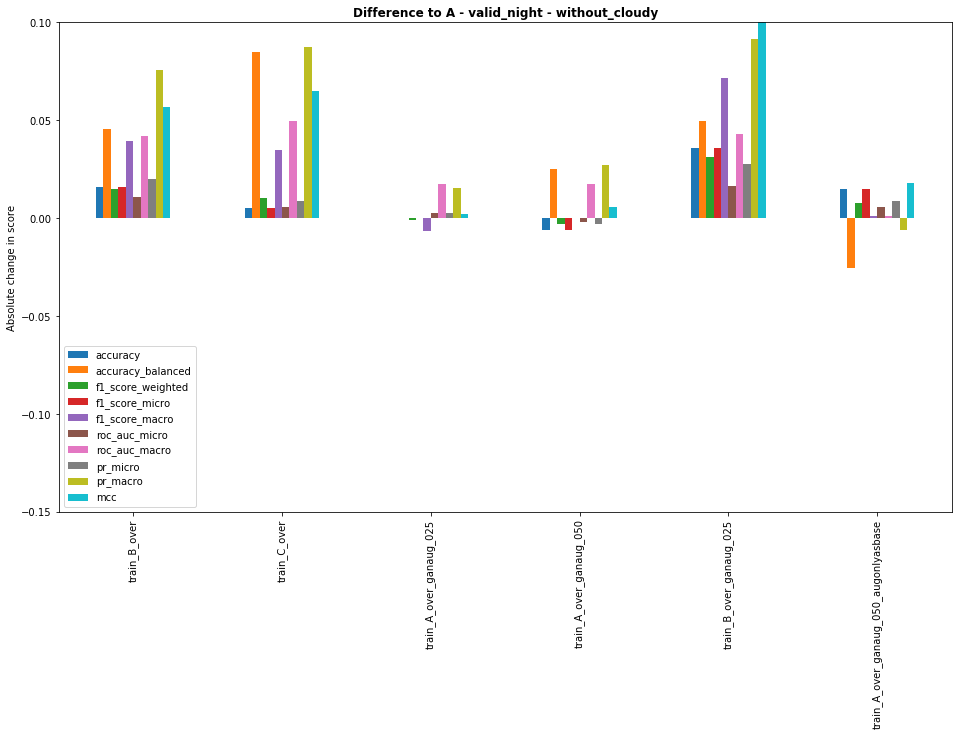

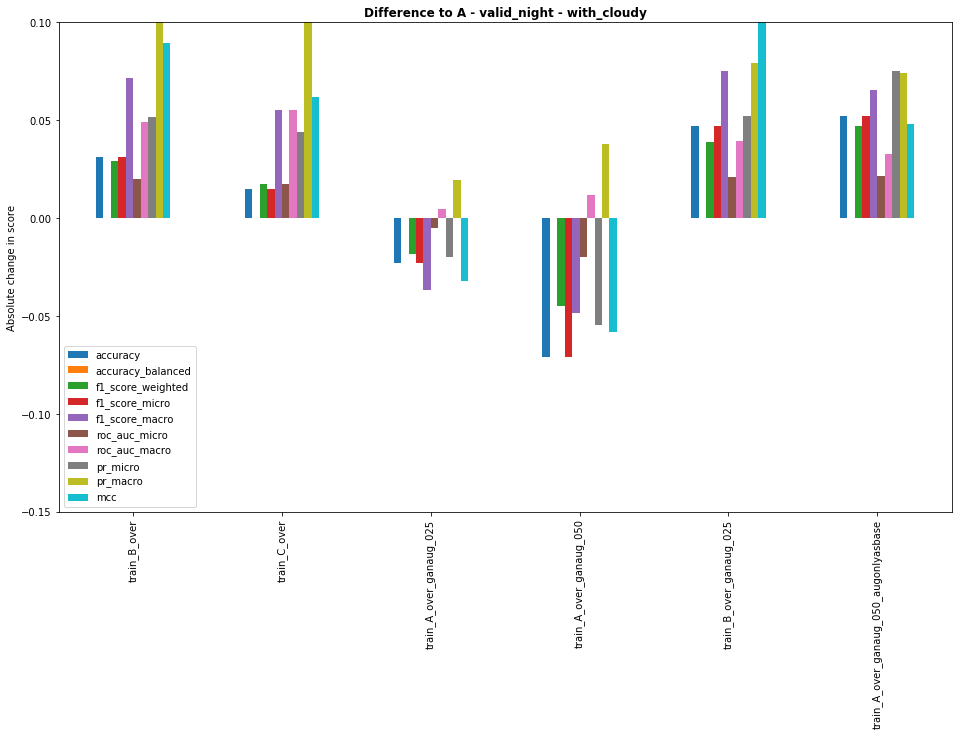

In [11]:
# plot difference
for trial in ["without_cloudy", "with_cloudy"]:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==trial, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {trial}", fontweight="bold")

#### Test-All

In [12]:
split = "test"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== test ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,30,train_A_over,without_cloudy,0.89884,0.795133,0.897838,0.89884,0.802813,0.969566,0.931167,0.947102,0.855978,0.71684
1,33,train_B_over,without_cloudy,0.902706,0.832954,0.903748,0.902706,0.821133,0.973552,0.944287,0.952568,0.882451,0.738103
2,35,train_C_over,without_cloudy,0.893686,0.841175,0.89677,0.893686,0.810137,0.969716,0.945825,0.944413,0.879115,0.726411
3,17,train_A_over_ganaug_025,without_cloudy,0.880799,0.803225,0.883691,0.880799,0.780963,0.96546,0.932996,0.939964,0.851505,0.687518
4,35,train_A_over_ganaug_050,without_cloudy,0.877577,0.812697,0.881826,0.877577,0.780049,0.962354,0.931405,0.933996,0.84886,0.687201
5,19,train_B_over_ganaug_025,without_cloudy,0.913015,0.818289,0.912103,0.913015,0.82681,0.973599,0.943301,0.954303,0.874226,0.756673
6,21,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.893041,0.799941,0.892986,0.893041,0.800081,0.968765,0.931421,0.946063,0.85205,0.705072
7,26,train_A_over,with_cloudy,0.848,NaN,0.84725,0.848,0.777563,0.959781,0.933174,0.902181,0.834952,0.728685
8,35,train_B_over,with_cloudy,0.8555,NaN,0.855876,0.8555,0.793282,0.962279,0.94287,0.902924,0.847821,0.745822
9,40,train_C_over,with_cloudy,0.8495,NaN,0.850207,0.8495,0.784015,0.960884,0.942846,0.901672,0.845498,0.735351


#### Test-Night

In [13]:
split = "test_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== test_night ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,18,train_A_over,without_cloudy,0.867368,0.667416,0.866626,0.867368,0.675203,0.949318,0.848092,0.911146,0.708182,0.523829
1,33,train_B_over,without_cloudy,0.888421,0.754395,0.889937,0.888421,0.740417,0.961358,0.889993,0.926588,0.789365,0.61835
2,32,train_C_over,without_cloudy,0.876842,0.753819,0.881796,0.876842,0.72287,0.957568,0.894332,0.918863,0.789804,0.599768
3,17,train_A_over_ganaug_025,without_cloudy,0.851579,0.676786,0.856586,0.851579,0.657608,0.948554,0.860516,0.908807,0.711058,0.508077
4,35,train_A_over_ganaug_050,without_cloudy,0.849474,0.707805,0.857507,0.849474,0.672255,0.944219,0.864036,0.899423,0.714381,0.5246
5,21,train_B_over_ganaug_025,without_cloudy,0.905263,0.725662,0.901815,0.905263,0.747082,0.96391,0.885761,0.935776,0.773081,0.648462
6,21,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.871579,0.657243,0.867908,0.871579,0.674993,0.952351,0.848969,0.914455,0.68698,0.523595
7,35,train_A_over,with_cloudy,0.859,NaN,0.852067,0.859,0.657703,0.950415,0.846709,0.885453,0.682197,0.565803
8,16,train_B_over,with_cloudy,0.867,NaN,0.866862,0.867,0.701427,0.957618,0.890373,0.892606,0.742923,0.623218
9,20,train_C_over,with_cloudy,0.842,NaN,0.844734,0.842,0.664078,0.950657,0.890584,0.873756,0.748002,0.570382


In [14]:
print("\n===", split, "Difference to A ===")
one_half = df_cursplit.shape[0]//2
df_cursplit_diff = df_cursplit.copy()
for col in df_cursplit.columns:
    if not isinstance(df_cursplit.loc[0,col], str):
        df_cursplit_diff.loc[0:one_half-1,col] = df_cursplit_diff.loc[0:one_half-1,col] - df_cursplit.loc[0,col]
        df_cursplit_diff.loc[one_half:one_half*2-1,col] = df_cursplit_diff.loc[one_half:one_half*2-1,col] - df_cursplit.loc[one_half,col]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== test_night Difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,0,train_A_over,without_cloudy,0,0,0,0,0,0,0,0,0,0
1,15,train_B_over,without_cloudy,0.0210526,0.0869788,0.0233113,0.0210526,0.0652143,0.0120404,0.041901,0.0154422,0.0811825,0.0945213
2,14,train_C_over,without_cloudy,0.00947368,0.0864029,0.0151702,0.00947368,0.047667,0.00824958,0.0462401,0.00771761,0.0816212,0.0759387
3,-1,train_A_over_ganaug_025,without_cloudy,-0.0157895,0.00936955,-0.0100394,-0.0157895,-0.0175952,-0.000763989,0.0124237,-0.00233835,0.00287599,-0.0157516
4,17,train_A_over_ganaug_050,without_cloudy,-0.0178947,0.0403888,-0.0091191,-0.0178947,-0.00294784,-0.00509917,0.0159434,-0.0117232,0.00619818,0.000770626
5,3,train_B_over_ganaug_025,without_cloudy,0.0378947,0.0582458,0.0351891,0.0378947,0.0718787,0.0145917,0.037669,0.0246303,0.0648984,0.124633
6,3,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.00421053,-0.0101733,0.00128184,0.00421053,-0.00021038,0.00303324,0.000876971,0.00330892,-0.0212024,-0.000234157
7,0,train_A_over,with_cloudy,0,NaN,0,0,0,0,0,0,0,0
8,-19,train_B_over,with_cloudy,0.008,NaN,0.014795,0.008,0.0437235,0.00720333,0.0436637,0.00715261,0.0607258,0.0574151
9,-15,train_C_over,with_cloudy,-0.017,NaN,-0.00733258,-0.017,0.0063744,0.0002415,0.0438746,-0.0116971,0.0658046,0.00457891


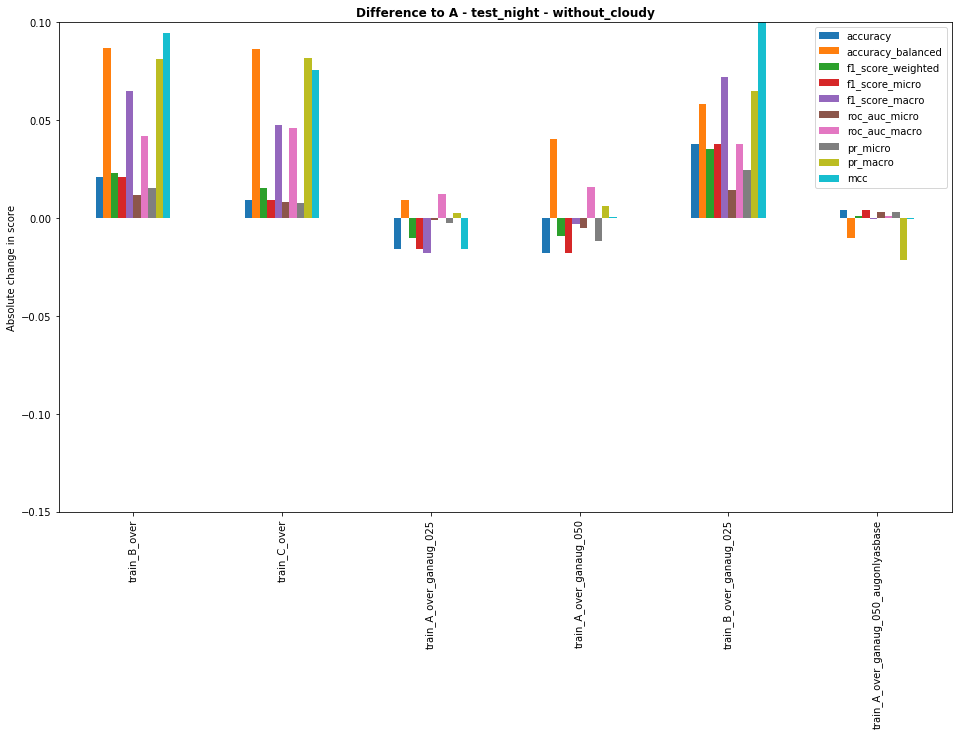

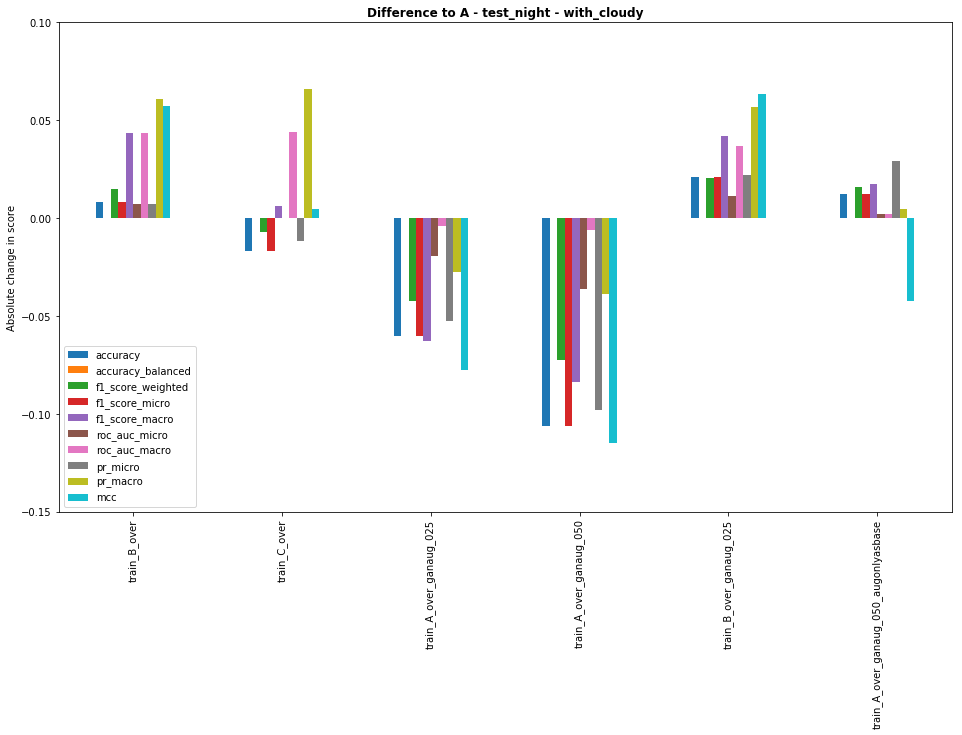

In [15]:
# plot difference
for trial in ["without_cloudy", "with_cloudy"]:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==trial, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {trial}", fontweight="bold")